In [5]:
# Importar as bibliotecas necessárias
import os
import time
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt

# Verificar se CUDA está disponível e definir o dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando o dispositivo: {device}")

# Definir as cores para as classes
CLASS_COLORS = { 
    'Doenca': (255, 0, 0), 
    'Saudavel': (0, 255, 0), 
    'Solo': (0, 0, 255) 
}

Usando o dispositivo: cuda


In [6]:
#definicao dos hiperparametros.
criterion = nn.CrossEntropyLoss()  # Considerando que temos múltiplas classes
# learning_rate = 0.001
num_epochs = 300
patience = 30
batch_size = 1

In [7]:
# Classe do Dataset personalizado
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        # Modificar a extensão da máscara para '.png'
        mask_name = os.path.splitext(img_name)[0] + '.png'
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        # Carregar a imagem e a máscara
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")
        
        if self.transform:
            # Aplicar transformações, se houver
            image = self.transform(image)
            mask = self.transform(mask)
            
        # Convertemos as máscaras de imagem em um array de índices de classe
        mask = self.mask_to_class(mask)
        
        return image, mask
    
    def mask_to_class(self, mask):
        # Converte a máscara para um array NumPy e ajusta para escala de 0 a 255
        mask_array = (np.array(mask, dtype=np.float32) * 255).astype(np.uint8)

        # Garantir que esté em [H, W, C]
        if mask_array.shape[0] == 3:
            mask_array = mask_array.transpose(1, 2, 0)

        mask_indices = np.zeros((mask_array.shape[0], mask_array.shape[1]), dtype=np.int64)

        for i, color in enumerate(CLASS_COLORS.values()):
            # Realizar comparação e detecção de igualdade entre pixels
            equal_color = np.all(mask_array == color, axis=-1)
            mask_indices[equal_color] = i

        return torch.tensor(mask_indices, dtype=torch.long)

# Função para criar transformações de dados normais e de aumento de dados
def get_transforms():
    return transforms.Compose([
        transforms.Resize((256, 256)),  # Redimensiona para uma dimensão adequada para o modelo
        transforms.ToTensor(),  # Normaliza para [0, 1]
    ])

# Outras inicializações de datasets e dataloaders
train_dataset = SegmentationDataset(
    image_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/base/Train",
    mask_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/masks/Train",
    transform=get_transforms()
)

val_dataset = SegmentationDataset(
    image_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/base/Val",
    mask_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/masks/Val",
    transform=get_transforms()
)

test_dataset = SegmentationDataset(
    image_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/base/Test",
    mask_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/masks/Test",
    transform=get_transforms()
)

# Criar os DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Dados carregados e preparados.")

Dados carregados e preparados.


In [8]:
# Importar a biblioteca segmentation-models-pytorch
!pip install segmentation-models-pytorch --quiet

import segmentation_models_pytorch as smp

# Inicializar as arquiteturas dos modelos com os pesos pretreinados por padrão
unet = smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=len(CLASS_COLORS)).to(device)
pspnet = smp.PSPNet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=len(CLASS_COLORS)).to(device)
linknet = smp.Linknet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=len(CLASS_COLORS)).to(device)
deeplabv3 = smp.DeepLabV3(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=len(CLASS_COLORS)).to(device)

models = {
    'U-Net': unet,
    'PSPNet': pspnet,
    'LinkNet': linknet
}

print("Modelos configurados e prontos para treinamento.")

Modelos configurados e prontos para treinamento.


In [9]:
import torch
import torchmetrics
import numpy as np
from torchmetrics.classification import MulticlassJaccardIndex, MulticlassF1Score, MulticlassPrecision

def compute_dice_coefficient(preds, targets):
    """
    Calcula o coeficiente de Dice
    """
    intersection = (preds * targets).sum()
    dice = (2. * intersection) / (preds.sum() + targets.sum())
    return dice.item()

def compute_aji(preds, targets):
    """
    Calcula o índice de Jaccard agregado (AJI)
    """
    preds = preds.detach().cpu().numpy().astype(np.bool_)
    targets = targets.detach().cpu().numpy().astype(np.bool_)
    
    # Calcula o Jaccard para cada componente individual nos targets/preds
    intersection = np.logical_and(preds, targets)
    union = np.logical_or(preds, targets)
    jaccard_per_class = intersection.sum() / (union.sum() + 1e-10)  # Evitar divisão por zero
    return jaccard_per_class

# Configurar as métricas, incluindo Dice e AJI personalizados
metrics = {
    'F1': MulticlassF1Score(num_classes=len(CLASS_COLORS)).to(device),
    'Jaccard': MulticlassJaccardIndex(num_classes=len(CLASS_COLORS)).to(device),
    'Precision': MulticlassPrecision(num_classes=len(CLASS_COLORS)).to(device),
    'Dice': compute_dice_coefficient,
    'AJI': compute_aji
}

In [10]:
def get_params_by_kind(model, n_base=7):
    base_vgg_bias = []
    base_vgg_weight = []
    core_weight = []
    core_bias = []

    for name, param in model.named_parameters():
        if 'vgg' in name and ('weight' in name or 'bias' in name):
            vgglayer = int(name.split('.')[-2])

            if vgglayer <= n_base:
                if 'bias' in name:
                    base_vgg_bias.append(param)
                else:
                    base_vgg_weight.append(param)
            else:
                if 'bias' in name:
                    core_bias.append(param)
                else:
                    core_weight.append(param)
        elif ('weight' in name or 'bias' in name):
            if 'bias' in name:
                core_bias.append(param)
            else:
                core_weight.append(param)

    return base_vgg_weight, base_vgg_bias, core_weight, core_bias

In [11]:
import csv
import time
import os
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# Configuração do diretório para salvar os resultados
results_dir = "E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/results/data"
os.makedirs(results_dir, exist_ok=True)

def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, metrics, num_epochs, device, patience, model_name, results_dir):
    since = time.time()
    best_model_wts = model.state_dict()
    best_loss = float('inf')
    patience_counter = 0
    epochs_run = 0  # Variável para contar as épocas realizadas

    # Variáveis para armazenar tempos de execução
    training_time = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        
        epochs_run += 1  # Registrar a execução da época

        epoch_start = time.time()  # Marcar o início da época

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader

            running_loss = 0.0
            running_metrics = {key: 0 for key in metrics.keys()}
            
            for inputs, masks in tqdm(data_loader):
                inputs, masks = inputs.to(device), masks.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, masks)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

                for metric_name, metric in metrics.items():
                    if metric_name in ['Dice', 'AJI']:
                        value = metric(preds, masks)
                    else:  # Para métricas torchmetrics
                        value = metric(preds, masks).item()
                    running_metrics[metric_name] += value * inputs.size(0)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_metrics = {key: value / len(data_loader.dataset) for key, value in running_metrics.items()}

            print(f'{phase} Loss: {epoch_loss:.4f}')
            for metric_name in metrics:
                print(f'{phase} {metric_name}: {epoch_metrics[metric_name]:.4f}')

            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1

        epoch_end = time.time()  # Marcar o fim da época
        epoch_time = epoch_end - epoch_start
        training_time += epoch_time  # Acumular tempos totais
        print(f'Epoch time: {epoch_time:.2f} seconds')

        print(f'Patience counter: {patience_counter}')

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {best_loss:.4f}')
    print(f'Total epochs run: {epochs_run}')

    # Restaurar o melhor modelo
    model.load_state_dict(best_model_wts)

    # Salvar o modelo treinado
    model_path = os.path.join(results_dir, f'{model_name}_best.pth')
    torch.save(model.state_dict(), model_path)

    # Coletar as métricas finais
    final_metrics = epoch_metrics
    final_metrics['best_loss'] = best_loss
    final_metrics['training_time'] = time_elapsed
    final_metrics['epochs_run'] = epochs_run

    # Salvar todas as métricas para CSV
    csv_path = os.path.join(results_dir, 'results.csv')
    write_metrics_to_csv(csv_path, model_name, final_metrics)

    return model

def write_metrics_to_csv(csv_path, model_name, metrics):
    headers = ['nome', 'f1-score', 'indice jaccard', 'precision', 'dice', 'aji', 'best_loss', 'training_time', 'epochs_run']
    row = [
        model_name,
        metrics['F1'],
        metrics['Jaccard'],
        metrics['Precision'],
        metrics['Dice'],
        metrics['AJI'],
        metrics['best_loss'],
        metrics['training_time'],
        metrics['epochs_run']
    ]

    file_exists = os.path.isfile(csv_path)

    with open(csv_path, mode='a', newline='') as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow(headers)  # Escrever cabeçalhos se o arquivo não existe
        writer.writerow(row)  # Salvar linha de métricas

# Executar o Treinamento dos Modelos
for model_name, model in models.items():
    print("*********************************************************************")
    print(f"Treinando {model_name} com early stopping.")
    
    # Defina os grupos de parâmetros para o modelo atual
    base_vgg_weight, base_vgg_bias, core_weight, core_bias = get_params_by_kind(model, 7)

    # Configurar o otimizador com diferentes learning rates para cada grupo de parâmetros
    optimizer = torch.optim.SGD([
        {'params': base_vgg_bias, 'lr': 0.00001},
        {'params': base_vgg_weight, 'lr': 0.00001},
        {'params': core_bias, 'lr': 0.02},
        {'params': core_weight, 'lr': 0.02, 'weight_decay': 0.0005}
    ], momentum=0.9)

    # Treinando o modelo
    trained_model = train_model_with_early_stopping(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        metrics=metrics,
        num_epochs=num_epochs,
        device=device,
        patience=patience,
        model_name=model_name,
        results_dir=results_dir
    )
    print(f'{model_name} treinado e salvo com sucesso.')

print("Treinamento completo de todos os modelos com early stopping.")

*********************************************************************
Treinando U-Net com early stopping.
Epoch 1/300
----------


100%|██████████| 80/80 [00:20<00:00,  3.98it/s]


train Loss: 0.9352
train F1: 0.4585
train Jaccard: 0.3407
train Precision: 0.5247
train Dice: 1.0291
train AJI: 0.3687


100%|██████████| 40/40 [00:08<00:00,  4.46it/s]


val Loss: 0.7922
val F1: 0.4351
val Jaccard: 0.3347
val Precision: 0.4950
val Dice: 0.8490
val AJI: 0.2868
Epoch time: 29.05 seconds
Patience counter: 0
Epoch 2/300
----------


100%|██████████| 80/80 [00:20<00:00,  3.96it/s]


train Loss: 0.6393
train F1: 0.6104
train Jaccard: 0.4919
train Precision: 0.6366
train Dice: 1.3242
train AJI: 0.5249


100%|██████████| 40/40 [00:08<00:00,  4.67it/s]


val Loss: 0.7381
val F1: 0.5423
val Jaccard: 0.4103
val Precision: 0.5980
val Dice: 1.1682
val AJI: 0.4998
Epoch time: 28.75 seconds
Patience counter: 0
Epoch 3/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.20it/s]


train Loss: 0.5311
train F1: 0.6508
train Jaccard: 0.5483
train Precision: 0.6763
train Dice: 1.3980
train AJI: 0.5911


100%|██████████| 40/40 [00:08<00:00,  4.52it/s]


val Loss: 0.5903
val F1: 0.5651
val Jaccard: 0.4669
val Precision: 0.6155
val Dice: 1.3926
val AJI: 0.5052
Epoch time: 27.90 seconds
Patience counter: 0
Epoch 4/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.18it/s]


train Loss: 0.4680
train F1: 0.7086
train Jaccard: 0.5986
train Precision: 0.7300
train Dice: 1.4199
train AJI: 0.6581


100%|██████████| 40/40 [00:09<00:00,  4.37it/s]


val Loss: 0.6296
val F1: 0.5738
val Jaccard: 0.4451
val Precision: 0.6095
val Dice: 1.1982
val AJI: 0.4770
Epoch time: 28.29 seconds
Patience counter: 1
Epoch 5/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.21it/s]


train Loss: 0.4267
train F1: 0.7182
train Jaccard: 0.6155
train Precision: 0.7496
train Dice: 1.4467
train AJI: 0.6654


100%|██████████| 40/40 [00:09<00:00,  4.35it/s]


val Loss: 0.8852
val F1: 0.5850
val Jaccard: 0.4644
val Precision: 0.6185
val Dice: 1.2617
val AJI: 0.5424
Epoch time: 28.20 seconds
Patience counter: 2
Epoch 6/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.20it/s]


train Loss: 0.3782
train F1: 0.7503
train Jaccard: 0.6527
train Precision: 0.7723
train Dice: 1.4628
train AJI: 0.6965


100%|██████████| 40/40 [00:08<00:00,  4.54it/s]


val Loss: 0.7189
val F1: 0.5797
val Jaccard: 0.4687
val Precision: 0.6085
val Dice: 1.3130
val AJI: 0.5157
Epoch time: 27.87 seconds
Patience counter: 3
Epoch 7/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.20it/s]


train Loss: 0.3124
train F1: 0.7893
train Jaccard: 0.6958
train Precision: 0.8051
train Dice: 1.4948
train AJI: 0.7623


100%|██████████| 40/40 [00:09<00:00,  4.32it/s]


val Loss: 0.5952
val F1: 0.6355
val Jaccard: 0.5081
val Precision: 0.6567
val Dice: 1.3232
val AJI: 0.5730
Epoch time: 28.29 seconds
Patience counter: 4
Epoch 8/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.13it/s]


train Loss: 0.2790
train F1: 0.8229
train Jaccard: 0.7360
train Precision: 0.8319
train Dice: 1.5180
train AJI: 0.7867


100%|██████████| 40/40 [00:08<00:00,  4.46it/s]


val Loss: 0.7657
val F1: 0.5870
val Jaccard: 0.4689
val Precision: 0.6296
val Dice: 1.2669
val AJI: 0.5494
Epoch time: 28.36 seconds
Patience counter: 5
Epoch 9/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.18it/s]


train Loss: 0.2540
train F1: 0.8202
train Jaccard: 0.7360
train Precision: 0.8267
train Dice: 1.5354
train AJI: 0.8000


100%|██████████| 40/40 [00:09<00:00,  4.36it/s]


val Loss: 0.9028
val F1: 0.5783
val Jaccard: 0.4658
val Precision: 0.6329
val Dice: 1.2988
val AJI: 0.5321
Epoch time: 28.29 seconds
Patience counter: 6
Epoch 10/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.21it/s]


train Loss: 0.2063
train F1: 0.8705
train Jaccard: 0.7963
train Precision: 0.8706
train Dice: 1.5571
train AJI: 0.8388


100%|██████████| 40/40 [00:09<00:00,  4.35it/s]


val Loss: 1.0116
val F1: 0.5799
val Jaccard: 0.4747
val Precision: 0.6688
val Dice: 1.3123
val AJI: 0.5026
Epoch time: 28.19 seconds
Patience counter: 7
Epoch 11/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.13it/s]


train Loss: 0.1970
train F1: 0.8856
train Jaccard: 0.8136
train Precision: 0.8874
train Dice: 1.5613
train AJI: 0.8462


100%|██████████| 40/40 [00:08<00:00,  4.61it/s]


val Loss: 0.9894
val F1: 0.5817
val Jaccard: 0.4696
val Precision: 0.6328
val Dice: 1.3142
val AJI: 0.5313
Epoch time: 28.03 seconds
Patience counter: 8
Epoch 12/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.22it/s]


train Loss: 0.1741
train F1: 0.8813
train Jaccard: 0.8144
train Precision: 0.8853
train Dice: 1.5745
train AJI: 0.8611


100%|██████████| 40/40 [00:08<00:00,  4.57it/s]


val Loss: 1.3984
val F1: 0.5723
val Jaccard: 0.4577
val Precision: 0.6262
val Dice: 1.3195
val AJI: 0.5501
Epoch time: 27.70 seconds
Patience counter: 9
Epoch 13/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.23it/s]


train Loss: 0.1534
train F1: 0.9024
train Jaccard: 0.8408
train Precision: 0.9018
train Dice: 1.5829
train AJI: 0.8777


100%|██████████| 40/40 [00:08<00:00,  4.45it/s]


val Loss: 1.3164
val F1: 0.5599
val Jaccard: 0.4597
val Precision: 0.6198
val Dice: 1.3344
val AJI: 0.5088
Epoch time: 27.90 seconds
Patience counter: 10
Epoch 14/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.24it/s]


train Loss: 0.1413
train F1: 0.9179
train Jaccard: 0.8589
train Precision: 0.9192
train Dice: 1.5889
train AJI: 0.8853


100%|██████████| 40/40 [00:08<00:00,  4.50it/s]


val Loss: 1.0142
val F1: 0.6029
val Jaccard: 0.4883
val Precision: 0.6648
val Dice: 1.3308
val AJI: 0.5383
Epoch time: 27.76 seconds
Patience counter: 11
Epoch 15/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.18it/s]


train Loss: 0.1229
train F1: 0.9271
train Jaccard: 0.8738
train Precision: 0.9280
train Dice: 1.6020
train AJI: 0.8972


100%|██████████| 40/40 [00:08<00:00,  4.82it/s]


val Loss: 1.3072
val F1: 0.5898
val Jaccard: 0.4776
val Precision: 0.6526
val Dice: 1.3150
val AJI: 0.5404
Epoch time: 27.42 seconds
Patience counter: 12
Epoch 16/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.23it/s]


train Loss: 0.1185
train F1: 0.9127
train Jaccard: 0.8612
train Precision: 0.9162
train Dice: 1.6066
train AJI: 0.9027


100%|██████████| 40/40 [00:09<00:00,  4.37it/s]


val Loss: 1.2190
val F1: 0.6068
val Jaccard: 0.4928
val Precision: 0.6692
val Dice: 1.3122
val AJI: 0.5317
Epoch time: 28.06 seconds
Patience counter: 13
Epoch 17/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.19it/s]


train Loss: 0.1086
train F1: 0.9254
train Jaccard: 0.8768
train Precision: 0.9259
train Dice: 1.6131
train AJI: 0.9099


100%|██████████| 40/40 [00:09<00:00,  4.37it/s]


val Loss: 1.2197
val F1: 0.6110
val Jaccard: 0.4945
val Precision: 0.6673
val Dice: 1.3136
val AJI: 0.5476
Epoch time: 28.24 seconds
Patience counter: 14
Epoch 18/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.17it/s]


train Loss: 0.1013
train F1: 0.9411
train Jaccard: 0.8942
train Precision: 0.9413
train Dice: 1.6159
train AJI: 0.9133


100%|██████████| 40/40 [00:08<00:00,  4.48it/s]


val Loss: 1.0767
val F1: 0.6007
val Jaccard: 0.4847
val Precision: 0.6653
val Dice: 1.3441
val AJI: 0.5477
Epoch time: 28.11 seconds
Patience counter: 15
Epoch 19/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.11it/s]


train Loss: 0.0953
train F1: 0.9453
train Jaccard: 0.9013
train Precision: 0.9454
train Dice: 1.6218
train AJI: 0.9193


100%|██████████| 40/40 [00:09<00:00,  4.38it/s]


val Loss: 0.8758
val F1: 0.6354
val Jaccard: 0.5168
val Precision: 0.6606
val Dice: 1.3290
val AJI: 0.5807
Epoch time: 28.59 seconds
Patience counter: 16
Epoch 20/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.19it/s]


train Loss: 0.0870
train F1: 0.9466
train Jaccard: 0.9061
train Precision: 0.9509
train Dice: 1.6265
train AJI: 0.9254


100%|██████████| 40/40 [00:09<00:00,  4.39it/s]


val Loss: 1.4053
val F1: 0.6164
val Jaccard: 0.4992
val Precision: 0.6734
val Dice: 1.3182
val AJI: 0.5567
Epoch time: 28.22 seconds
Patience counter: 17
Epoch 21/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.24it/s]


train Loss: 0.0858
train F1: 0.9521
train Jaccard: 0.9111
train Precision: 0.9528
train Dice: 1.6286
train AJI: 0.9261


100%|██████████| 40/40 [00:08<00:00,  4.51it/s]


val Loss: 1.0547
val F1: 0.6216
val Jaccard: 0.5071
val Precision: 0.6635
val Dice: 1.3456
val AJI: 0.5680
Epoch time: 27.74 seconds
Patience counter: 18
Epoch 22/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.24it/s]


train Loss: 0.0815
train F1: 0.9522
train Jaccard: 0.9136
train Precision: 0.9522
train Dice: 1.6328
train AJI: 0.9303


100%|██████████| 40/40 [00:08<00:00,  4.47it/s]


val Loss: 1.4342
val F1: 0.6232
val Jaccard: 0.5062
val Precision: 0.6546
val Dice: 1.3269
val AJI: 0.5707
Epoch time: 27.82 seconds
Patience counter: 19
Epoch 23/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.19it/s]


train Loss: 0.0778
train F1: 0.9545
train Jaccard: 0.9175
train Precision: 0.9551
train Dice: 1.6350
train AJI: 0.9334


100%|██████████| 40/40 [00:08<00:00,  4.53it/s]


val Loss: 1.6693
val F1: 0.6204
val Jaccard: 0.5051
val Precision: 0.6580
val Dice: 1.3229
val AJI: 0.5697
Epoch time: 27.91 seconds
Patience counter: 20
Epoch 24/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.10it/s]


train Loss: 0.0716
train F1: 0.9573
train Jaccard: 0.9226
train Precision: 0.9573
train Dice: 1.6390
train AJI: 0.9376


100%|██████████| 40/40 [00:08<00:00,  4.56it/s]


val Loss: 1.2973
val F1: 0.6079
val Jaccard: 0.4929
val Precision: 0.6608
val Dice: 1.3449
val AJI: 0.5579
Epoch time: 28.27 seconds
Patience counter: 21
Epoch 25/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.18it/s]


train Loss: 0.0707
train F1: 0.9619
train Jaccard: 0.9276
train Precision: 0.9626
train Dice: 1.6388
train AJI: 0.9386


100%|██████████| 40/40 [00:09<00:00,  4.36it/s]


val Loss: 1.3483
val F1: 0.6216
val Jaccard: 0.5051
val Precision: 0.6519
val Dice: 1.3267
val AJI: 0.5748
Epoch time: 28.31 seconds
Patience counter: 22
Epoch 26/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.14it/s]


train Loss: 0.0678
train F1: 0.9633
train Jaccard: 0.9301
train Precision: 0.9636
train Dice: 1.6412
train AJI: 0.9407


100%|██████████| 40/40 [00:09<00:00,  4.43it/s]


val Loss: 1.5063
val F1: 0.6219
val Jaccard: 0.5050
val Precision: 0.6514
val Dice: 1.3345
val AJI: 0.5777
Epoch time: 28.38 seconds
Patience counter: 23
Epoch 27/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.21it/s]


train Loss: 0.0652
train F1: 0.9606
train Jaccard: 0.9286
train Precision: 0.9611
train Dice: 1.6424
train AJI: 0.9426


100%|██████████| 40/40 [00:08<00:00,  4.45it/s]


val Loss: 2.8571
val F1: 0.6035
val Jaccard: 0.4911
val Precision: 0.6443
val Dice: 1.3361
val AJI: 0.5554
Epoch time: 28.00 seconds
Patience counter: 24
Epoch 28/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.24it/s]


train Loss: 0.0645
train F1: 0.9611
train Jaccard: 0.9295
train Precision: 0.9610
train Dice: 1.6437
train AJI: 0.9439


100%|██████████| 40/40 [00:08<00:00,  4.45it/s]


val Loss: 1.6722
val F1: 0.6173
val Jaccard: 0.5021
val Precision: 0.6517
val Dice: 1.3319
val AJI: 0.5792
Epoch time: 27.87 seconds
Patience counter: 25
Epoch 29/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.27it/s]


train Loss: 0.0643
train F1: 0.9611
train Jaccard: 0.9296
train Precision: 0.9619
train Dice: 1.6440
train AJI: 0.9442


100%|██████████| 40/40 [00:09<00:00,  4.39it/s]


val Loss: 1.7544
val F1: 0.6157
val Jaccard: 0.4994
val Precision: 0.6663
val Dice: 1.3355
val AJI: 0.5540
Epoch time: 27.85 seconds
Patience counter: 26
Epoch 30/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.17it/s]


train Loss: 0.0599
train F1: 0.9637
train Jaccard: 0.9342
train Precision: 0.9640
train Dice: 1.6471
train AJI: 0.9476


100%|██████████| 40/40 [00:08<00:00,  4.46it/s]


val Loss: 1.3618
val F1: 0.6222
val Jaccard: 0.5054
val Precision: 0.6655
val Dice: 1.3214
val AJI: 0.5788
Epoch time: 28.17 seconds
Patience counter: 27
Epoch 31/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.24it/s]


train Loss: 0.0584
train F1: 0.9688
train Jaccard: 0.9402
train Precision: 0.9687
train Dice: 1.6499
train AJI: 0.9494


100%|██████████| 40/40 [00:09<00:00,  4.40it/s]


val Loss: 1.4043
val F1: 0.6219
val Jaccard: 0.5037
val Precision: 0.6609
val Dice: 1.3456
val AJI: 0.5661
Epoch time: 27.98 seconds
Patience counter: 28
Epoch 32/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.13it/s]


train Loss: 0.0590
train F1: 0.9649
train Jaccard: 0.9365
train Precision: 0.9654
train Dice: 1.6509
train AJI: 0.9493


100%|██████████| 40/40 [00:09<00:00,  4.42it/s]


val Loss: 1.4622
val F1: 0.6310
val Jaccard: 0.5128
val Precision: 0.6743
val Dice: 1.3200
val AJI: 0.5763
Epoch time: 28.41 seconds
Patience counter: 29
Epoch 33/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.22it/s]


train Loss: 0.0585
train F1: 0.9571
train Jaccard: 0.9291
train Precision: 0.9580
train Dice: 1.6506
train AJI: 0.9497


100%|██████████| 40/40 [00:08<00:00,  4.45it/s]


val Loss: 1.2207
val F1: 0.6325
val Jaccard: 0.5136
val Precision: 0.6707
val Dice: 1.3280
val AJI: 0.5750
Epoch time: 27.94 seconds
Patience counter: 30
Early stopping triggered.
Training complete in 15m 28s
Best val loss: 0.5903
Total epochs run: 33
U-Net treinado e salvo com sucesso.
*********************************************************************
Treinando PSPNet com early stopping.
Epoch 1/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.23it/s]


train Loss: 6.2854
train F1: 0.3657
train Jaccard: 0.2604
train Precision: 0.4338
train Dice: 0.8904
train AJI: 0.3812


100%|██████████| 40/40 [00:08<00:00,  4.69it/s]


val Loss: 9.2050
val F1: 0.4627
val Jaccard: 0.3413
val Precision: 0.5003
val Dice: 1.1641
val AJI: 0.5093
Epoch time: 27.47 seconds
Patience counter: 0
Epoch 2/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.17it/s]


train Loss: 1.8495
train F1: 0.4407
train Jaccard: 0.3264
train Precision: 0.5052
train Dice: 0.9937
train AJI: 0.3833


100%|██████████| 40/40 [00:08<00:00,  4.69it/s]


val Loss: 1.2401
val F1: 0.4310
val Jaccard: 0.3372
val Precision: 0.4629
val Dice: 1.1183
val AJI: 0.3939
Epoch time: 27.70 seconds
Patience counter: 0
Epoch 3/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.18it/s]


train Loss: 1.5884
train F1: 0.4685
train Jaccard: 0.3534
train Precision: 0.5445
train Dice: 1.0540
train AJI: 0.4095


100%|██████████| 40/40 [00:08<00:00,  4.69it/s]


val Loss: 1.4005
val F1: 0.4905
val Jaccard: 0.3800
val Precision: 0.5212
val Dice: 1.0987
val AJI: 0.3524
Epoch time: 27.66 seconds
Patience counter: 1
Epoch 4/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.13it/s]


train Loss: 0.8988
train F1: 0.5646
train Jaccard: 0.4406
train Precision: 0.6211
train Dice: 1.1579
train AJI: 0.4696


100%|██████████| 40/40 [00:08<00:00,  4.74it/s]


val Loss: 0.8535
val F1: 0.5234
val Jaccard: 0.3965
val Precision: 0.5572
val Dice: 1.2195
val AJI: 0.4754
Epoch time: 27.80 seconds
Patience counter: 0
Epoch 5/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.14it/s]


train Loss: 0.7838
train F1: 0.5902
train Jaccard: 0.4695
train Precision: 0.6495
train Dice: 1.2244
train AJI: 0.5150


100%|██████████| 40/40 [00:08<00:00,  4.73it/s]


val Loss: 2.5297
val F1: 0.4665
val Jaccard: 0.3652
val Precision: 0.4884
val Dice: 1.1710
val AJI: 0.4001
Epoch time: 27.75 seconds
Patience counter: 1
Epoch 6/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.14it/s]


train Loss: 0.7978
train F1: 0.6045
train Jaccard: 0.4769
train Precision: 0.6474
train Dice: 1.2338
train AJI: 0.5182


100%|██████████| 40/40 [00:08<00:00,  4.68it/s]


val Loss: 2.3694
val F1: 0.5168
val Jaccard: 0.3990
val Precision: 0.5516
val Dice: 1.2239
val AJI: 0.4268
Epoch time: 27.90 seconds
Patience counter: 2
Epoch 7/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.15it/s]


train Loss: 0.6424
train F1: 0.6289
train Jaccard: 0.5064
train Precision: 0.6728
train Dice: 1.2888
train AJI: 0.5424


100%|██████████| 40/40 [00:08<00:00,  4.72it/s]


val Loss: 2.4549
val F1: 0.5121
val Jaccard: 0.3999
val Precision: 0.5594
val Dice: 1.1808
val AJI: 0.4077
Epoch time: 27.77 seconds
Patience counter: 3
Epoch 8/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.14it/s]


train Loss: 0.5752
train F1: 0.6652
train Jaccard: 0.5448
train Precision: 0.7120
train Dice: 1.3196
train AJI: 0.5871


100%|██████████| 40/40 [00:08<00:00,  4.74it/s]


val Loss: 3.2066
val F1: 0.5212
val Jaccard: 0.4098
val Precision: 0.6058
val Dice: 1.1743
val AJI: 0.4315
Epoch time: 27.77 seconds
Patience counter: 4
Epoch 9/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.16it/s]


train Loss: 0.5181
train F1: 0.6966
train Jaccard: 0.5763
train Precision: 0.7286
train Dice: 1.3459
train AJI: 0.6131


100%|██████████| 40/40 [00:08<00:00,  4.69it/s]


val Loss: 3.3413
val F1: 0.4543
val Jaccard: 0.3377
val Precision: 0.5420
val Dice: 1.0095
val AJI: 0.4406
Epoch time: 27.75 seconds
Patience counter: 5
Epoch 10/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.23it/s]


train Loss: 0.5157
train F1: 0.6967
train Jaccard: 0.5783
train Precision: 0.7277
train Dice: 1.3570
train AJI: 0.6223


100%|██████████| 40/40 [00:08<00:00,  4.68it/s]


val Loss: 1.9489
val F1: 0.5458
val Jaccard: 0.4277
val Precision: 0.5805
val Dice: 1.2429
val AJI: 0.4562
Epoch time: 27.47 seconds
Patience counter: 6
Epoch 11/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.18it/s]


train Loss: 0.4709
train F1: 0.7148
train Jaccard: 0.5989
train Precision: 0.7455
train Dice: 1.3764
train AJI: 0.6478


100%|██████████| 40/40 [00:08<00:00,  4.74it/s]


val Loss: 2.4921
val F1: 0.5233
val Jaccard: 0.4024
val Precision: 0.5554
val Dice: 1.1969
val AJI: 0.4428
Epoch time: 27.59 seconds
Patience counter: 7
Epoch 12/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.19it/s]


train Loss: 0.4898
train F1: 0.7091
train Jaccard: 0.5900
train Precision: 0.7399
train Dice: 1.3658
train AJI: 0.6333


100%|██████████| 40/40 [00:08<00:00,  4.63it/s]


val Loss: 3.1435
val F1: 0.4651
val Jaccard: 0.3554
val Precision: 0.5573
val Dice: 1.1984
val AJI: 0.5046
Epoch time: 27.73 seconds
Patience counter: 8
Epoch 13/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.26it/s]


train Loss: 0.4779
train F1: 0.7212
train Jaccard: 0.6038
train Precision: 0.7517
train Dice: 1.3755
train AJI: 0.6399


100%|██████████| 40/40 [00:08<00:00,  4.69it/s]


val Loss: 7.2283
val F1: 0.5189
val Jaccard: 0.4040
val Precision: 0.5737
val Dice: 1.1400
val AJI: 0.3509
Epoch time: 27.32 seconds
Patience counter: 9
Epoch 14/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.17it/s]


train Loss: 0.4627
train F1: 0.7184
train Jaccard: 0.6023
train Precision: 0.7404
train Dice: 1.3782
train AJI: 0.6568


100%|██████████| 40/40 [00:08<00:00,  4.65it/s]


val Loss: 18.0231
val F1: 0.4442
val Jaccard: 0.3262
val Precision: 0.5834
val Dice: 0.7212
val AJI: 0.2506
Epoch time: 27.76 seconds
Patience counter: 10
Epoch 15/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.13it/s]


train Loss: 0.4374
train F1: 0.7370
train Jaccard: 0.6236
train Precision: 0.7567
train Dice: 1.3914
train AJI: 0.6764


100%|██████████| 40/40 [00:08<00:00,  4.73it/s]


val Loss: 3.2094
val F1: 0.5167
val Jaccard: 0.3987
val Precision: 0.5235
val Dice: 1.2047
val AJI: 0.4598
Epoch time: 27.82 seconds
Patience counter: 11
Epoch 16/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.21it/s]


train Loss: 0.4136
train F1: 0.7556
train Jaccard: 0.6403
train Precision: 0.7827
train Dice: 1.4035
train AJI: 0.6788


100%|██████████| 40/40 [00:08<00:00,  4.74it/s]


val Loss: 4.1286
val F1: 0.4519
val Jaccard: 0.3320
val Precision: 0.5168
val Dice: 1.0071
val AJI: 0.4057
Epoch time: 27.46 seconds
Patience counter: 12
Epoch 17/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.14it/s]


train Loss: 0.4198
train F1: 0.7334
train Jaccard: 0.6234
train Precision: 0.7641
train Dice: 1.4082
train AJI: 0.6814


100%|██████████| 40/40 [00:08<00:00,  4.73it/s]


val Loss: 10.9439
val F1: 0.4403
val Jaccard: 0.3203
val Precision: 0.5592
val Dice: 0.8396
val AJI: 0.2503
Epoch time: 27.78 seconds
Patience counter: 13
Epoch 18/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.14it/s]


train Loss: 0.3820
train F1: 0.7688
train Jaccard: 0.6592
train Precision: 0.7860
train Dice: 1.4291
train AJI: 0.7047


100%|██████████| 40/40 [00:08<00:00,  4.72it/s]


val Loss: 3.9442
val F1: 0.4668
val Jaccard: 0.3615
val Precision: 0.5072
val Dice: 1.0956
val AJI: 0.3473
Epoch time: 27.79 seconds
Patience counter: 14
Epoch 19/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.16it/s]


train Loss: 0.3873
train F1: 0.7683
train Jaccard: 0.6576
train Precision: 0.7900
train Dice: 1.4195
train AJI: 0.7069


100%|██████████| 40/40 [00:08<00:00,  4.75it/s]


val Loss: 4.2038
val F1: 0.4955
val Jaccard: 0.3664
val Precision: 0.5410
val Dice: 1.0614
val AJI: 0.4106
Epoch time: 27.68 seconds
Patience counter: 15
Epoch 20/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.10it/s]


train Loss: 0.3568
train F1: 0.7874
train Jaccard: 0.6812
train Precision: 0.8027
train Dice: 1.4452
train AJI: 0.7300


100%|██████████| 40/40 [00:08<00:00,  4.75it/s]


val Loss: 9.0913
val F1: 0.4425
val Jaccard: 0.3150
val Precision: 0.5476
val Dice: 0.8895
val AJI: 0.2884
Epoch time: 27.93 seconds
Patience counter: 16
Epoch 21/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.18it/s]


train Loss: 0.3495
train F1: 0.8019
train Jaccard: 0.6972
train Precision: 0.8172
train Dice: 1.4394
train AJI: 0.7294


100%|██████████| 40/40 [00:08<00:00,  4.68it/s]


val Loss: 2.4663
val F1: 0.5454
val Jaccard: 0.4219
val Precision: 0.5728
val Dice: 1.2076
val AJI: 0.4672
Epoch time: 27.69 seconds
Patience counter: 17
Epoch 22/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.19it/s]


train Loss: 0.3359
train F1: 0.7991
train Jaccard: 0.6950
train Precision: 0.8097
train Dice: 1.4577
train AJI: 0.7408


100%|██████████| 40/40 [00:08<00:00,  4.74it/s]


val Loss: 4.4755
val F1: 0.5111
val Jaccard: 0.3867
val Precision: 0.5383
val Dice: 1.2079
val AJI: 0.4802
Epoch time: 27.56 seconds
Patience counter: 18
Epoch 23/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.18it/s]


train Loss: 0.3298
train F1: 0.7888
train Jaccard: 0.6864
train Precision: 0.8028
train Dice: 1.4637
train AJI: 0.7454


100%|██████████| 40/40 [00:08<00:00,  4.71it/s]


val Loss: 5.1148
val F1: 0.4772
val Jaccard: 0.3573
val Precision: 0.5703
val Dice: 0.9452
val AJI: 0.3231
Epoch time: 27.63 seconds
Patience counter: 19
Epoch 24/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.19it/s]


train Loss: 0.3216
train F1: 0.8068
train Jaccard: 0.7061
train Precision: 0.8221
train Dice: 1.4608
train AJI: 0.7470


100%|██████████| 40/40 [00:08<00:00,  4.70it/s]


val Loss: 2.0005
val F1: 0.4827
val Jaccard: 0.3623
val Precision: 0.5366
val Dice: 1.0846
val AJI: 0.4514
Epoch time: 27.60 seconds
Patience counter: 20
Epoch 25/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.16it/s]


train Loss: 0.3177
train F1: 0.7985
train Jaccard: 0.6974
train Precision: 0.8070
train Dice: 1.4643
train AJI: 0.7497


100%|██████████| 40/40 [00:08<00:00,  4.68it/s]


val Loss: 10.9954
val F1: 0.4101
val Jaccard: 0.3012
val Precision: 0.5420
val Dice: 0.6892
val AJI: 0.2299
Epoch time: 27.78 seconds
Patience counter: 21
Epoch 26/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.18it/s]


train Loss: 0.2990
train F1: 0.8283
train Jaccard: 0.7292
train Precision: 0.8420
train Dice: 1.4655
train AJI: 0.7644


100%|██████████| 40/40 [00:08<00:00,  4.70it/s]


val Loss: 5.8662
val F1: 0.4633
val Jaccard: 0.3360
val Precision: 0.5162
val Dice: 0.9916
val AJI: 0.3609
Epoch time: 27.68 seconds
Patience counter: 22
Epoch 27/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.19it/s]


train Loss: 0.2900
train F1: 0.8401
train Jaccard: 0.7423
train Precision: 0.8493
train Dice: 1.4799
train AJI: 0.7710


100%|██████████| 40/40 [00:08<00:00,  4.71it/s]


val Loss: 10.8507
val F1: 0.3717
val Jaccard: 0.2660
val Precision: 0.4654
val Dice: 0.7318
val AJI: 0.1984
Epoch time: 27.60 seconds
Patience counter: 23
Epoch 28/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.13it/s]


train Loss: 0.2804
train F1: 0.8363
train Jaccard: 0.7407
train Precision: 0.8509
train Dice: 1.4825
train AJI: 0.7729


100%|██████████| 40/40 [00:08<00:00,  4.75it/s]


val Loss: 14.4192
val F1: 0.5251
val Jaccard: 0.4019
val Precision: 0.6114
val Dice: 1.0450
val AJI: 0.3603
Epoch time: 27.79 seconds
Patience counter: 24
Epoch 29/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.18it/s]


train Loss: 0.2714
train F1: 0.8425
train Jaccard: 0.7493
train Precision: 0.8530
train Dice: 1.4945
train AJI: 0.7842


100%|██████████| 40/40 [00:08<00:00,  4.70it/s]


val Loss: 5.1014
val F1: 0.4690
val Jaccard: 0.3467
val Precision: 0.5509
val Dice: 1.0017
val AJI: 0.3908
Epoch time: 27.67 seconds
Patience counter: 25
Epoch 30/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.12it/s]


train Loss: 0.2862
train F1: 0.8345
train Jaccard: 0.7391
train Precision: 0.8457
train Dice: 1.4865
train AJI: 0.7775


100%|██████████| 40/40 [00:08<00:00,  4.78it/s]


val Loss: 15.5600
val F1: 0.3554
val Jaccard: 0.2643
val Precision: 0.5235
val Dice: 0.5370
val AJI: 0.1375
Epoch time: 27.77 seconds
Patience counter: 26
Epoch 31/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.12it/s]


train Loss: 0.2658
train F1: 0.8484
train Jaccard: 0.7570
train Precision: 0.8535
train Dice: 1.4981
train AJI: 0.7907


100%|██████████| 40/40 [00:08<00:00,  4.73it/s]


val Loss: 9.6046
val F1: 0.4135
val Jaccard: 0.3138
val Precision: 0.5236
val Dice: 0.7566
val AJI: 0.2210
Epoch time: 27.89 seconds
Patience counter: 27
Epoch 32/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.13it/s]


train Loss: 0.2566
train F1: 0.8514
train Jaccard: 0.7608
train Precision: 0.8623
train Dice: 1.5019
train AJI: 0.7955


100%|██████████| 40/40 [00:08<00:00,  4.72it/s]


val Loss: 14.3440
val F1: 0.3923
val Jaccard: 0.2915
val Precision: 0.4504
val Dice: 0.8159
val AJI: 0.2704
Epoch time: 27.84 seconds
Patience counter: 28
Epoch 33/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.12it/s]


train Loss: 0.2439
train F1: 0.8665
train Jaccard: 0.7782
train Precision: 0.8733
train Dice: 1.5104
train AJI: 0.8075


100%|██████████| 40/40 [00:08<00:00,  4.74it/s]


val Loss: 4.7870
val F1: 0.4582
val Jaccard: 0.3363
val Precision: 0.5083
val Dice: 1.0810
val AJI: 0.3792
Epoch time: 27.87 seconds
Patience counter: 29
Epoch 34/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.16it/s]


train Loss: 0.2252
train F1: 0.8696
train Jaccard: 0.7859
train Precision: 0.8764
train Dice: 1.5206
train AJI: 0.8229


100%|██████████| 40/40 [00:08<00:00,  4.71it/s]


val Loss: 5.1142
val F1: 0.4844
val Jaccard: 0.3600
val Precision: 0.5209
val Dice: 1.0598
val AJI: 0.3546
Epoch time: 27.75 seconds
Patience counter: 30
Early stopping triggered.
Training complete in 15m 42s
Best val loss: 0.8535
Total epochs run: 34
PSPNet treinado e salvo com sucesso.
*********************************************************************
Treinando LinkNet com early stopping.
Epoch 1/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.19it/s]


train Loss: 0.8746
train F1: 0.4500
train Jaccard: 0.3386
train Precision: 0.5130
train Dice: 1.0408
train AJI: 0.3747


100%|██████████| 40/40 [00:08<00:00,  4.49it/s]


val Loss: 0.6495
val F1: 0.5511
val Jaccard: 0.4221
val Precision: 0.6027
val Dice: 1.2866
val AJI: 0.5313
Epoch time: 28.01 seconds
Patience counter: 0
Epoch 2/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.24it/s]


train Loss: 0.5962
train F1: 0.6111
train Jaccard: 0.5009
train Precision: 0.6328
train Dice: 1.3659
train AJI: 0.5532


100%|██████████| 40/40 [00:09<00:00,  4.31it/s]


val Loss: 0.7357
val F1: 0.5199
val Jaccard: 0.3996
val Precision: 0.5924
val Dice: 1.1934
val AJI: 0.4606
Epoch time: 28.13 seconds
Patience counter: 1
Epoch 3/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.27it/s]


train Loss: 0.4912
train F1: 0.6940
train Jaccard: 0.5817
train Precision: 0.7073
train Dice: 1.4215
train AJI: 0.6460


100%|██████████| 40/40 [00:09<00:00,  4.35it/s]


val Loss: 0.7397
val F1: 0.5273
val Jaccard: 0.4120
val Precision: 0.6056
val Dice: 1.2210
val AJI: 0.4705
Epoch time: 27.94 seconds
Patience counter: 2
Epoch 4/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.26it/s]


train Loss: 0.4040
train F1: 0.7507
train Jaccard: 0.6435
train Precision: 0.7584
train Dice: 1.4556
train AJI: 0.7051


100%|██████████| 40/40 [00:09<00:00,  4.36it/s]


val Loss: 0.9927
val F1: 0.5244
val Jaccard: 0.4251
val Precision: 0.6068
val Dice: 1.1108
val AJI: 0.3884
Epoch time: 27.96 seconds
Patience counter: 3
Epoch 5/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.23it/s]


train Loss: 0.3664
train F1: 0.7697
train Jaccard: 0.6736
train Precision: 0.7896
train Dice: 1.4876
train AJI: 0.7344


100%|██████████| 40/40 [00:09<00:00,  4.21it/s]


val Loss: 0.5545
val F1: 0.6440
val Jaccard: 0.5236
val Precision: 0.6889
val Dice: 1.3511
val AJI: 0.5811
Epoch time: 28.43 seconds
Patience counter: 0
Epoch 6/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.23it/s]


train Loss: 0.3073
train F1: 0.7927
train Jaccard: 0.7042
train Precision: 0.8053
train Dice: 1.5178
train AJI: 0.7720


100%|██████████| 40/40 [00:09<00:00,  4.27it/s]


val Loss: 0.9330
val F1: 0.5519
val Jaccard: 0.4250
val Precision: 0.6213
val Dice: 1.1691
val AJI: 0.4920
Epoch time: 28.27 seconds
Patience counter: 1
Epoch 7/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.25it/s]


train Loss: 0.2818
train F1: 0.8221
train Jaccard: 0.7351
train Precision: 0.8304
train Dice: 1.5214
train AJI: 0.7865


100%|██████████| 40/40 [00:09<00:00,  4.30it/s]


val Loss: 0.6996
val F1: 0.6430
val Jaccard: 0.5233
val Precision: 0.6944
val Dice: 1.3513
val AJI: 0.5827
Epoch time: 28.12 seconds
Patience counter: 2
Epoch 8/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.25it/s]


train Loss: 0.2489
train F1: 0.8420
train Jaccard: 0.7624
train Precision: 0.8452
train Dice: 1.5386
train AJI: 0.8099


100%|██████████| 40/40 [00:09<00:00,  4.29it/s]


val Loss: 0.8437
val F1: 0.5708
val Jaccard: 0.4468
val Precision: 0.6476
val Dice: 1.2629
val AJI: 0.5636
Epoch time: 28.14 seconds
Patience counter: 3
Epoch 9/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.25it/s]


train Loss: 0.2272
train F1: 0.8473
train Jaccard: 0.7728
train Precision: 0.8541
train Dice: 1.5494
train AJI: 0.8249


100%|██████████| 40/40 [00:09<00:00,  4.35it/s]


val Loss: 0.8415
val F1: 0.5703
val Jaccard: 0.4604
val Precision: 0.6652
val Dice: 1.3094
val AJI: 0.5168
Epoch time: 28.04 seconds
Patience counter: 4
Epoch 10/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.24it/s]


train Loss: 0.1815
train F1: 0.8912
train Jaccard: 0.8247
train Precision: 0.8894
train Dice: 1.5707
train AJI: 0.8581


100%|██████████| 40/40 [00:09<00:00,  4.42it/s]


val Loss: 1.0940
val F1: 0.5695
val Jaccard: 0.4544
val Precision: 0.6615
val Dice: 1.3291
val AJI: 0.5444
Epoch time: 27.90 seconds
Patience counter: 5
Epoch 11/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.19it/s]


train Loss: 0.1608
train F1: 0.8996
train Jaccard: 0.8384
train Precision: 0.8961
train Dice: 1.5814
train AJI: 0.8714


100%|██████████| 40/40 [00:08<00:00,  4.47it/s]


val Loss: 1.0656
val F1: 0.5714
val Jaccard: 0.4685
val Precision: 0.7095
val Dice: 1.3403
val AJI: 0.5226
Epoch time: 28.06 seconds
Patience counter: 6
Epoch 12/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.23it/s]


train Loss: 0.1383
train F1: 0.9172
train Jaccard: 0.8620
train Precision: 0.9143
train Dice: 1.5970
train AJI: 0.8889


100%|██████████| 40/40 [00:09<00:00,  4.35it/s]


val Loss: 1.1537
val F1: 0.5722
val Jaccard: 0.4720
val Precision: 0.6948
val Dice: 1.3300
val AJI: 0.5191
Epoch time: 28.10 seconds
Patience counter: 7
Epoch 13/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.26it/s]


train Loss: 0.1210
train F1: 0.9257
train Jaccard: 0.8751
train Precision: 0.9257
train Dice: 1.6089
train AJI: 0.9021


100%|██████████| 40/40 [00:08<00:00,  4.45it/s]


val Loss: 0.9019
val F1: 0.6120
val Jaccard: 0.4987
val Precision: 0.7068
val Dice: 1.3558
val AJI: 0.5543
Epoch time: 27.78 seconds
Patience counter: 8
Epoch 14/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.23it/s]


train Loss: 0.1148
train F1: 0.9217
train Jaccard: 0.8732
train Precision: 0.9203
train Dice: 1.6093
train AJI: 0.9045


100%|██████████| 40/40 [00:09<00:00,  4.28it/s]


val Loss: 1.1903
val F1: 0.5977
val Jaccard: 0.4853
val Precision: 0.7067
val Dice: 1.3451
val AJI: 0.5546
Epoch time: 28.27 seconds
Patience counter: 9
Epoch 15/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.23it/s]


train Loss: 0.1017
train F1: 0.9415
train Jaccard: 0.8976
train Precision: 0.9410
train Dice: 1.6192
train AJI: 0.9174


100%|██████████| 40/40 [00:09<00:00,  4.30it/s]


val Loss: 0.9473
val F1: 0.6421
val Jaccard: 0.5260
val Precision: 0.7140
val Dice: 1.3538
val AJI: 0.5930
Epoch time: 28.22 seconds
Patience counter: 10
Epoch 16/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.30it/s]


train Loss: 0.0910
train F1: 0.9416
train Jaccard: 0.9011
train Precision: 0.9412
train Dice: 1.6262
train AJI: 0.9251


100%|██████████| 40/40 [00:09<00:00,  4.44it/s]


val Loss: 0.9013
val F1: 0.6413
val Jaccard: 0.5235
val Precision: 0.7114
val Dice: 1.3612
val AJI: 0.5948
Epoch time: 27.62 seconds
Patience counter: 11
Epoch 17/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.28it/s]


train Loss: 0.0840
train F1: 0.9515
train Jaccard: 0.9130
train Precision: 0.9527
train Dice: 1.6314
train AJI: 0.9306


100%|██████████| 40/40 [00:09<00:00,  4.38it/s]


val Loss: 1.1562
val F1: 0.6029
val Jaccard: 0.4896
val Precision: 0.6883
val Dice: 1.3356
val AJI: 0.5529
Epoch time: 27.82 seconds
Patience counter: 12
Epoch 18/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.22it/s]


train Loss: 0.0803
train F1: 0.9540
train Jaccard: 0.9169
train Precision: 0.9534
train Dice: 1.6343
train AJI: 0.9337


100%|██████████| 40/40 [00:09<00:00,  4.43it/s]


val Loss: 1.0351
val F1: 0.6087
val Jaccard: 0.4919
val Precision: 0.7008
val Dice: 1.3392
val AJI: 0.5586
Epoch time: 28.00 seconds
Patience counter: 13
Epoch 19/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.26it/s]


train Loss: 0.0732
train F1: 0.9534
train Jaccard: 0.9190
train Precision: 0.9540
train Dice: 1.6387
train AJI: 0.9390


100%|██████████| 40/40 [00:09<00:00,  4.30it/s]


val Loss: 0.7624
val F1: 0.6728
val Jaccard: 0.5600
val Precision: 0.7113
val Dice: 1.4461
val AJI: 0.6434
Epoch time: 28.11 seconds
Patience counter: 14
Epoch 20/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.17it/s]


train Loss: 0.0690
train F1: 0.9478
train Jaccard: 0.9155
train Precision: 0.9475
train Dice: 1.6422
train AJI: 0.9421


100%|██████████| 40/40 [00:08<00:00,  4.53it/s]


val Loss: 1.1053
val F1: 0.6364
val Jaccard: 0.5181
val Precision: 0.7108
val Dice: 1.3490
val AJI: 0.5860
Epoch time: 28.00 seconds
Patience counter: 15
Epoch 21/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.20it/s]


train Loss: 0.0665
train F1: 0.9450
train Jaccard: 0.9139
train Precision: 0.9447
train Dice: 1.6438
train AJI: 0.9442


100%|██████████| 40/40 [00:09<00:00,  4.35it/s]


val Loss: 1.0336
val F1: 0.6312
val Jaccard: 0.5128
val Precision: 0.6918
val Dice: 1.3559
val AJI: 0.5909
Epoch time: 28.23 seconds
Patience counter: 16
Epoch 22/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.25it/s]


train Loss: 0.0653
train F1: 0.9497
train Jaccard: 0.9191
train Precision: 0.9497
train Dice: 1.6458
train AJI: 0.9454


100%|██████████| 40/40 [00:09<00:00,  4.42it/s]


val Loss: 1.1439
val F1: 0.6434
val Jaccard: 0.5228
val Precision: 0.6989
val Dice: 1.3468
val AJI: 0.5912
Epoch time: 27.90 seconds
Patience counter: 17
Epoch 23/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.23it/s]


train Loss: 0.0645
train F1: 0.9505
train Jaccard: 0.9205
train Precision: 0.9505
train Dice: 1.6468
train AJI: 0.9466


100%|██████████| 40/40 [00:09<00:00,  4.42it/s]


val Loss: 1.2831
val F1: 0.6374
val Jaccard: 0.5158
val Precision: 0.6980
val Dice: 1.3292
val AJI: 0.5821
Epoch time: 27.98 seconds
Patience counter: 18
Epoch 24/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.25it/s]


train Loss: 0.0627
train F1: 0.9432
train Jaccard: 0.9140
train Precision: 0.9433
train Dice: 1.6479
train AJI: 0.9475


100%|██████████| 40/40 [00:09<00:00,  4.32it/s]


val Loss: 1.4433
val F1: 0.6087
val Jaccard: 0.4916
val Precision: 0.6799
val Dice: 1.3115
val AJI: 0.5518
Epoch time: 28.09 seconds
Patience counter: 19
Epoch 25/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.25it/s]


train Loss: 0.0597
train F1: 0.9485
train Jaccard: 0.9203
train Precision: 0.9480
train Dice: 1.6498
train AJI: 0.9497


100%|██████████| 40/40 [00:09<00:00,  4.38it/s]


val Loss: 1.3266
val F1: 0.6093
val Jaccard: 0.4946
val Precision: 0.6941
val Dice: 1.3375
val AJI: 0.5566
Epoch time: 27.94 seconds
Patience counter: 20
Epoch 26/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.26it/s]


train Loss: 0.0570
train F1: 0.9627
train Jaccard: 0.9359
train Precision: 0.9627
train Dice: 1.6525
train AJI: 0.9526


100%|██████████| 40/40 [00:09<00:00,  4.40it/s]


val Loss: 1.4357
val F1: 0.6052
val Jaccard: 0.4923
val Precision: 0.6953
val Dice: 1.3439
val AJI: 0.5578
Epoch time: 27.89 seconds
Patience counter: 21
Epoch 27/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.25it/s]


train Loss: 0.0548
train F1: 0.9634
train Jaccard: 0.9372
train Precision: 0.9631
train Dice: 1.6529
train AJI: 0.9540


100%|██████████| 40/40 [00:09<00:00,  4.41it/s]


val Loss: 1.2530
val F1: 0.6109
val Jaccard: 0.4944
val Precision: 0.6905
val Dice: 1.3403
val AJI: 0.5664
Epoch time: 27.89 seconds
Patience counter: 22
Epoch 28/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.19it/s]


train Loss: 0.0528
train F1: 0.9606
train Jaccard: 0.9355
train Precision: 0.9609
train Dice: 1.6549
train AJI: 0.9557


100%|██████████| 40/40 [00:09<00:00,  4.40it/s]


val Loss: 1.1176
val F1: 0.6300
val Jaccard: 0.5107
val Precision: 0.6933
val Dice: 1.3443
val AJI: 0.5825
Epoch time: 28.19 seconds
Patience counter: 23
Epoch 29/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.20it/s]


train Loss: 0.0515
train F1: 0.9574
train Jaccard: 0.9332
train Precision: 0.9571
train Dice: 1.6556
train AJI: 0.9569


100%|██████████| 40/40 [00:08<00:00,  4.45it/s]


val Loss: 1.1969
val F1: 0.5952
val Jaccard: 0.4822
val Precision: 0.6871
val Dice: 1.3508
val AJI: 0.5530
Epoch time: 28.03 seconds
Patience counter: 24
Epoch 30/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.26it/s]


train Loss: 0.0515
train F1: 0.9613
train Jaccard: 0.9370
train Precision: 0.9612
train Dice: 1.6558
train AJI: 0.9567


100%|██████████| 40/40 [00:08<00:00,  4.47it/s]


val Loss: 1.7414
val F1: 0.6262
val Jaccard: 0.5072
val Precision: 0.6784
val Dice: 1.3177
val AJI: 0.5752
Epoch time: 27.75 seconds
Patience counter: 25
Epoch 31/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.22it/s]


train Loss: 0.0509
train F1: 0.9652
train Jaccard: 0.9407
train Precision: 0.9656
train Dice: 1.6567
train AJI: 0.9573


100%|██████████| 40/40 [00:08<00:00,  4.46it/s]


val Loss: 1.7332
val F1: 0.5994
val Jaccard: 0.4843
val Precision: 0.6842
val Dice: 1.3041
val AJI: 0.5500
Epoch time: 27.93 seconds
Patience counter: 26
Epoch 32/300
----------


100%|██████████| 80/80 [00:19<00:00,  4.21it/s]


train Loss: 0.0575
train F1: 0.9452
train Jaccard: 0.9180
train Precision: 0.9448
train Dice: 1.6535
train AJI: 0.9523


100%|██████████| 40/40 [00:09<00:00,  4.39it/s]


val Loss: 0.9845
val F1: 0.6559
val Jaccard: 0.5344
val Precision: 0.6983
val Dice: 1.3696
val AJI: 0.6040
Epoch time: 28.15 seconds
Patience counter: 27
Epoch 33/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.24it/s]


train Loss: 0.0530
train F1: 0.9597
train Jaccard: 0.9340
train Precision: 0.9599
train Dice: 1.6554
train AJI: 0.9555


100%|██████████| 40/40 [00:08<00:00,  4.47it/s]


val Loss: 1.2110
val F1: 0.6286
val Jaccard: 0.5099
val Precision: 0.6958
val Dice: 1.3433
val AJI: 0.5737
Epoch time: 27.82 seconds
Patience counter: 28
Epoch 34/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.21it/s]


train Loss: 0.0498
train F1: 0.9576
train Jaccard: 0.9337
train Precision: 0.9571
train Dice: 1.6575
train AJI: 0.9584


100%|██████████| 40/40 [00:09<00:00,  4.41it/s]


val Loss: 1.3766
val F1: 0.6046
val Jaccard: 0.4902
val Precision: 0.6908
val Dice: 1.3318
val AJI: 0.5494
Epoch time: 28.07 seconds
Patience counter: 29
Epoch 35/300
----------


100%|██████████| 80/80 [00:18<00:00,  4.24it/s]


train Loss: 0.0454
train F1: 0.9684
train Jaccard: 0.9467
train Precision: 0.9686
train Dice: 1.6607
train AJI: 0.9621


100%|██████████| 40/40 [00:09<00:00,  4.41it/s]

val Loss: 1.4735
val F1: 0.6135
val Jaccard: 0.4957
val Precision: 0.6907
val Dice: 1.3363
val AJI: 0.5656
Epoch time: 27.92 seconds
Patience counter: 30
Early stopping triggered.
Training complete in 16m 21s
Best val loss: 0.5545
Total epochs run: 35
LinkNet treinado e salvo com sucesso.
Treinamento completo de todos os modelos com early stopping.


C:\Users\Henrique Moreira\AppData\Local\Temp\ipykernel_30036\2253927742.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load(trained

Visualizando e salvando predições para U-Net...
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


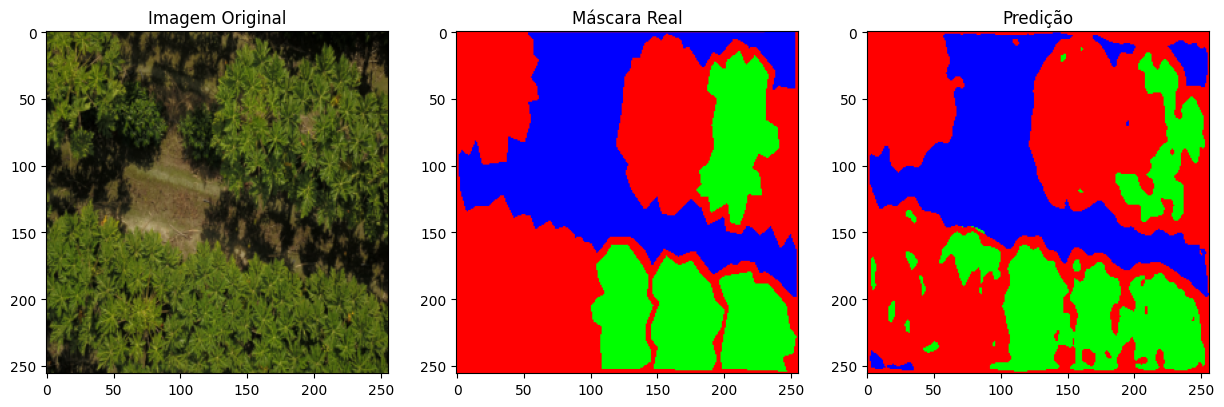

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


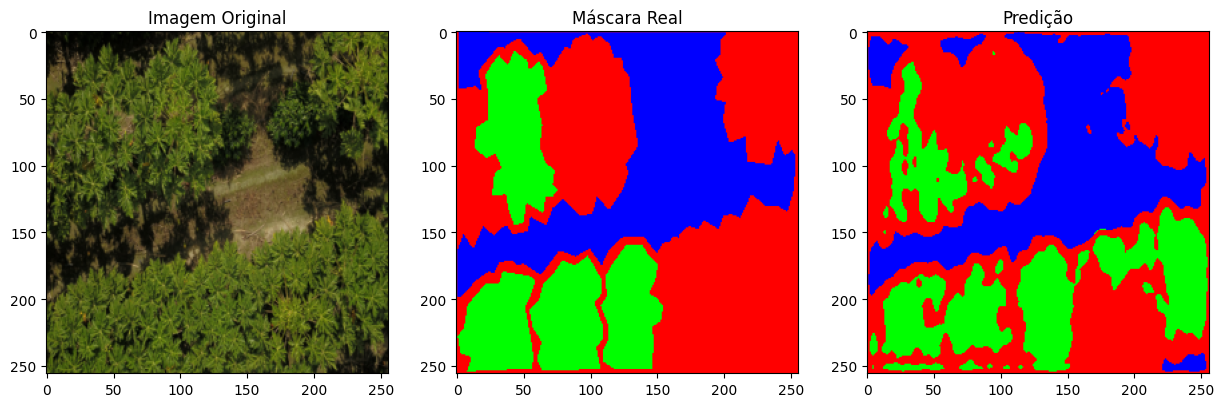

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


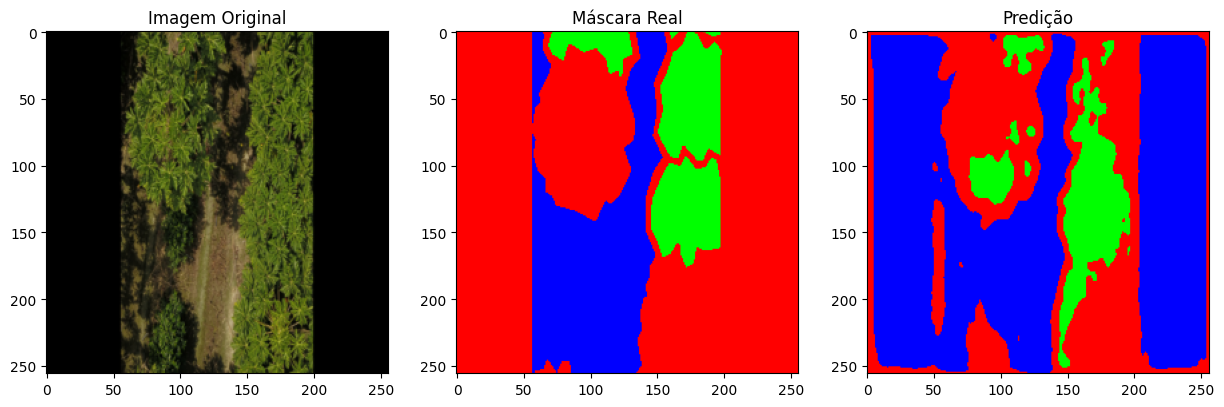

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


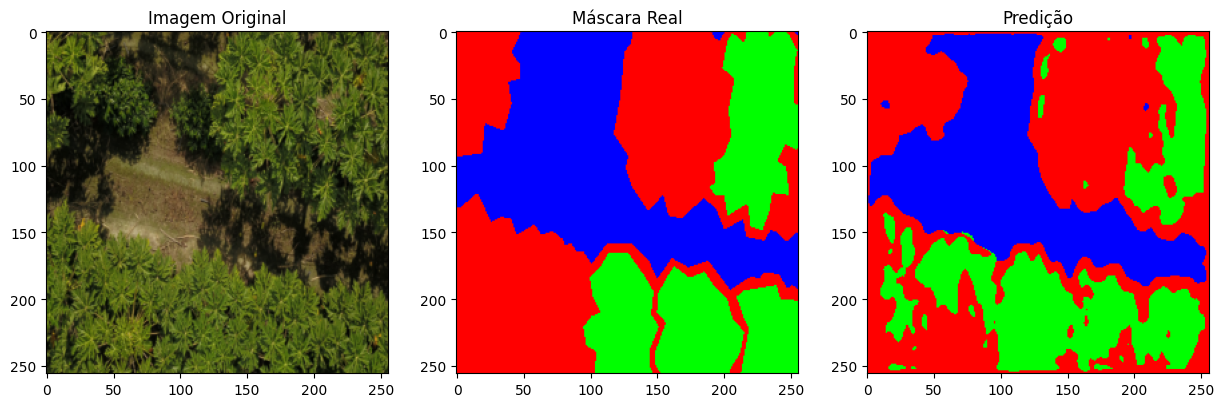

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


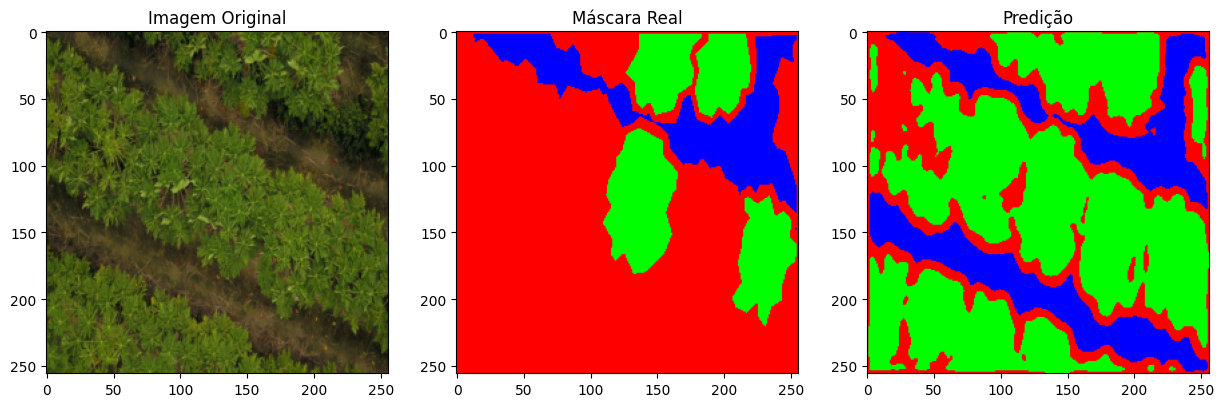

Visualizando e salvando predições para PSPNet...
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


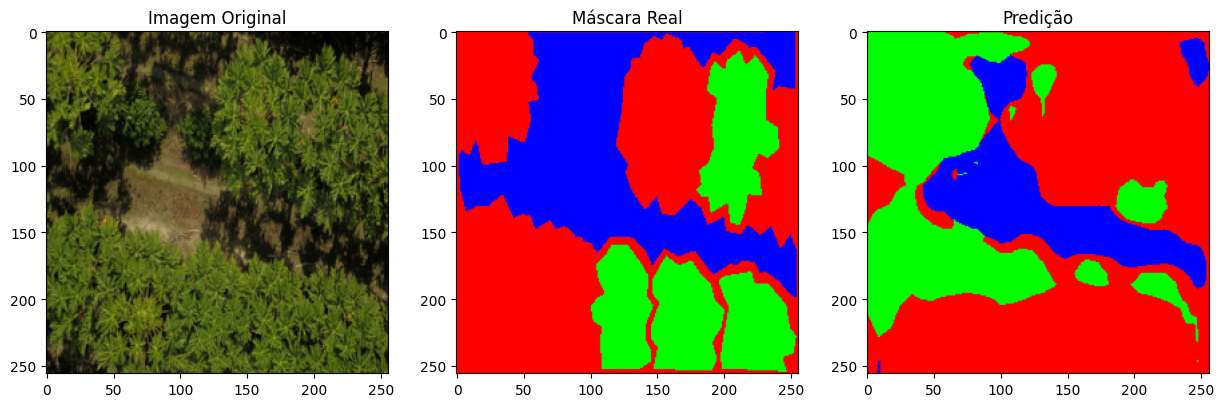

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


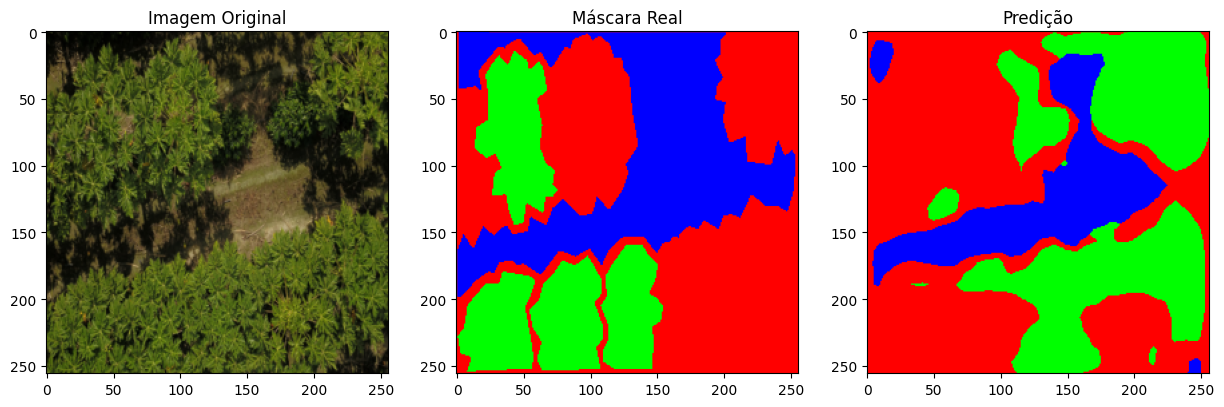

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


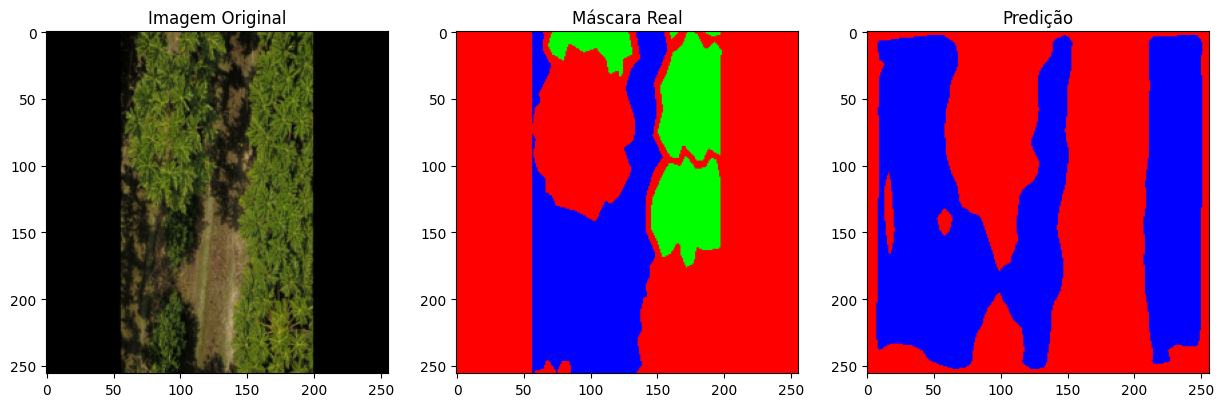

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


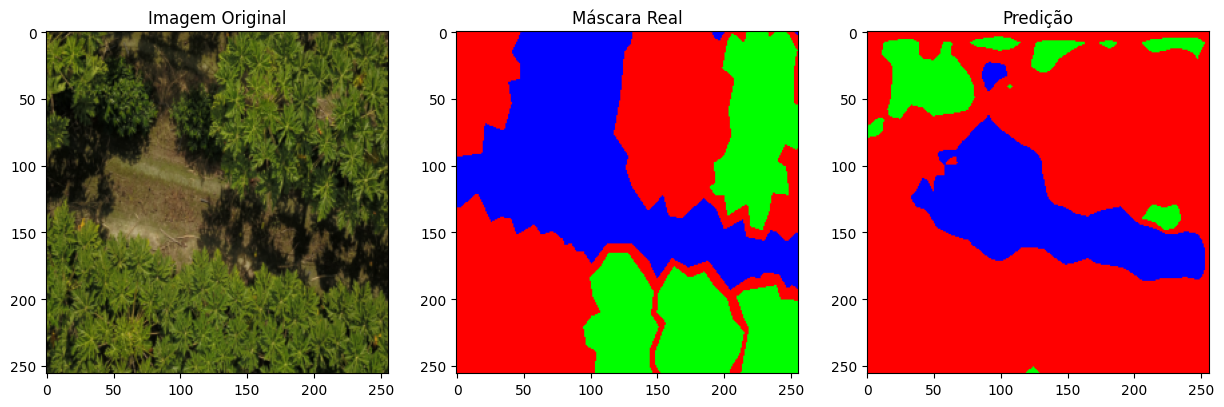

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


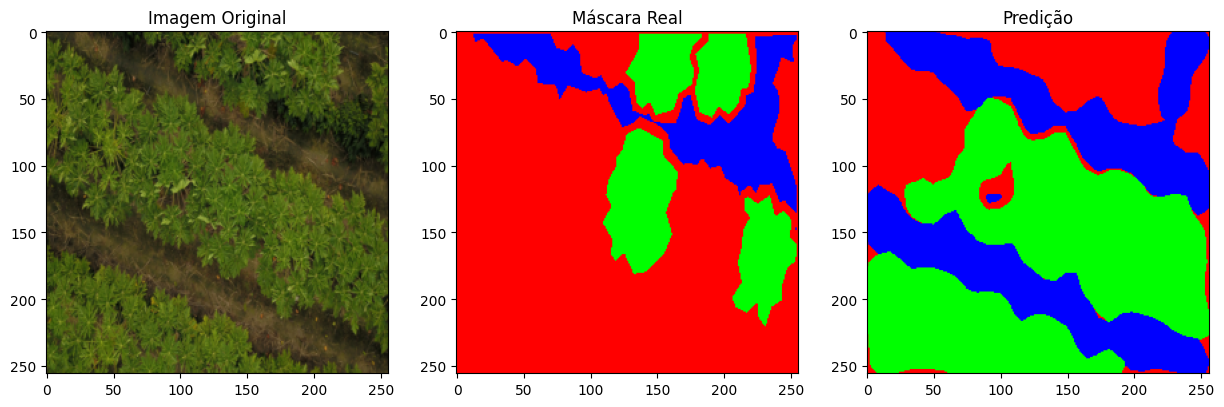

Visualizando e salvando predições para LinkNet...
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


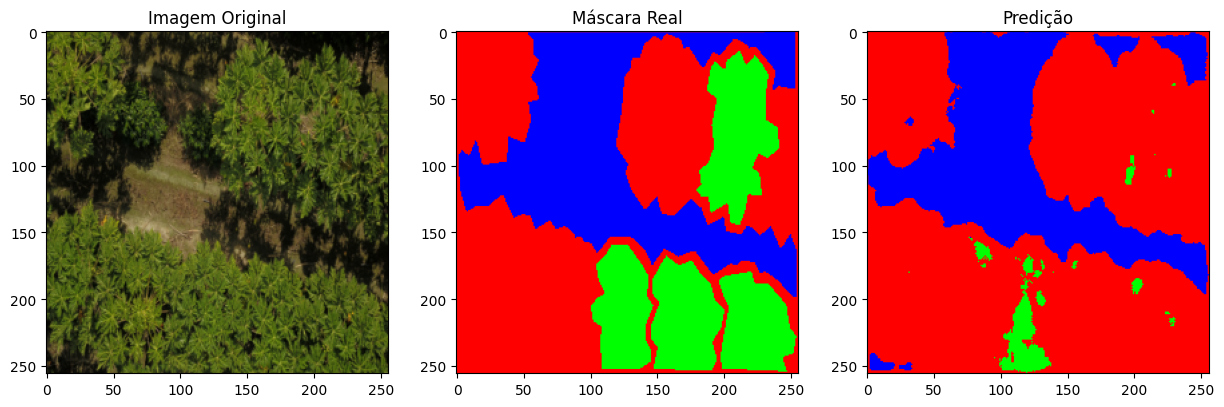

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


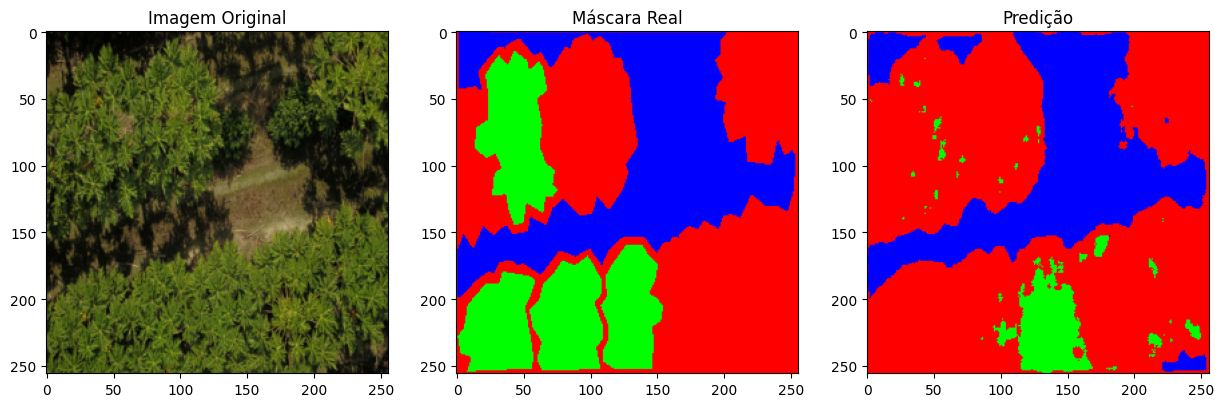

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


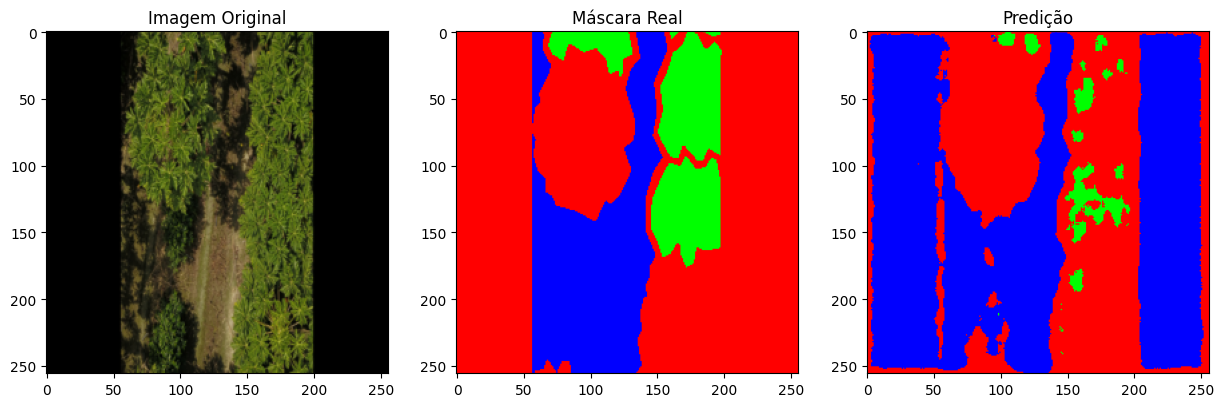

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


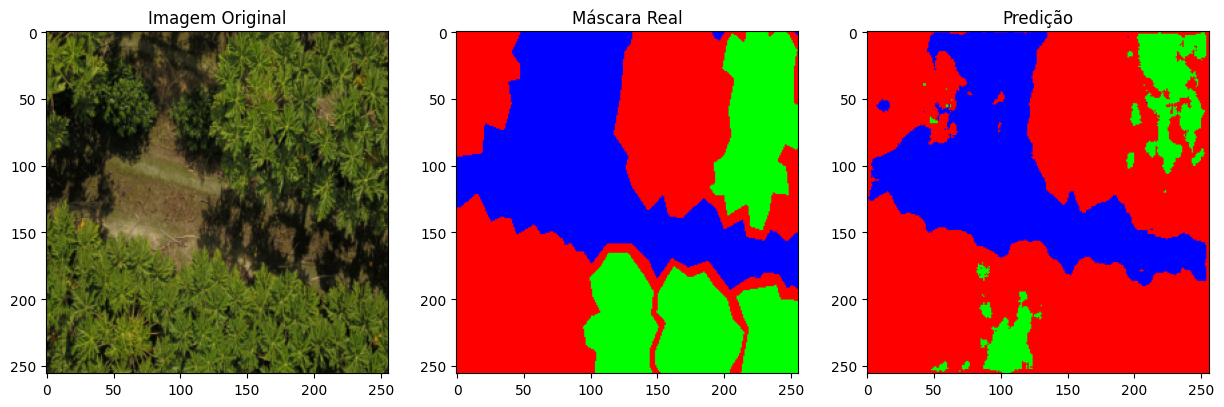

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


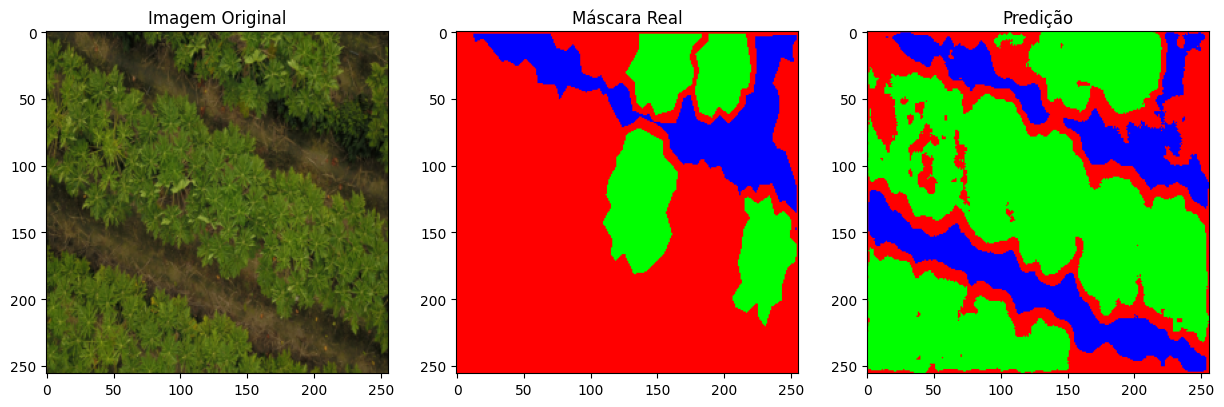

Visualização e salvamento concluídos!


In [12]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

# Diretório para salvar os resultados das imagens
results_dir = "E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/results/images"
os.makedirs(results_dir, exist_ok=True)

# Diretório onde os arquivos do modelo foram salvados
model_dir = "E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/results/data" 

# Função auxiliar para transformar índices de classe em cores RGB
def class_to_rgb(mask_indices):
    mask_rgb = np.zeros((mask_indices.shape[0], mask_indices.shape[1], 3), dtype=np.uint8)
    unique_classes = np.unique(mask_indices)
    print(f"Unique classes in mask: {unique_classes}")  # Log para classes únicas

    for class_index, color in enumerate(CLASS_COLORS.values()):
        mask_rgb[mask_indices == class_index] = color
        print(f"Mapping class {class_index} to color {color}")  # Log para mapeamento
    return mask_rgb

# Função para visualizar e salvar predições
def visualize_and_save_predictions(model, data_loader, device, results_dir, model_name, num_images=5):
    model.eval()
    images_saved = 0

    with torch.no_grad():
        for inputs, masks in data_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                images_saved += 1
                if images_saved > num_images:
                    return
                
                # Processamento para visualização
                image = (inputs[i].cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
                
                # Conversão de índices para RGB
                mask = class_to_rgb(masks[i].cpu().numpy())
                prediction = class_to_rgb(preds[i].cpu().numpy())

                # Logs para depuração
                print(f"Input shape: {inputs[i].shape}")
                print(f"Mask shape: {masks[i].shape}")
                print(f"Prediction shape: {preds[i].shape}")

                # Visualização
                plt.figure(figsize=(15, 5))
                
                plt.subplot(1, 3, 1)
                plt.imshow(image)
                plt.title('Imagem Original')

                plt.subplot(1, 3, 2)
                plt.imshow(mask)
                plt.title('Máscara Real')

                plt.subplot(1, 3, 3)
                plt.imshow(prediction)
                plt.title('Predição')

                plt.show()
                
                # Salvar as imagens
                plt.imsave(os.path.join(results_dir, f'{model_name}_input_{images_saved}.png'), image)
                plt.imsave(os.path.join(results_dir, f'{model_name}_mask_{images_saved}.png'), mask)
                plt.imsave(os.path.join(results_dir, f'{model_name}_prediction_{images_saved}.png'), prediction)

# Executar para cada modelo
for model_name, model in models.items():
    print(f"Visualizando e salvando predições para {model_name}...")
    
    trained_model = model
    trained_model_path = os.path.join(model_dir, f'{model_name}_best.pth')
    trained_model.load_state_dict(torch.load(trained_model_path))
    trained_model.to(device)
    
    visualize_and_save_predictions(trained_model, test_loader, device, results_dir, model_name, num_images=5)

print("Visualização e salvamento concluídos!")